In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm

from pathlib import Path


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-01 13:47:21.294287: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 13:47:21.318824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 13:47:21.318851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 13:47:21.319925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 13:47:21.324713: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 13:47:21.325512: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
# dataset = "ovarian"
dataset = "breast"
use_saved = False

if dataset == "breast":
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  

    # data (as pandas dataframes) 
    batch_size=151
    X = cdc_diabetes_health_indicators.data.features
    y = cdc_diabetes_health_indicators.data.targets

    X = X.fillna(0)
    batch_size=300
    
else:
    X = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
    y = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)
    batch_size = 6

X_scaled = (X - X.mean())/X.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(253680, 21)


In [6]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [7]:
if not use_saved:

    if dataset == "ovarian":
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1e-6)
    else:
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1.)
        
else:
    import dill as pickle
    import gzip
    if dataset == 'ovarian':
        with gzip.open("ovarian_gwas.gz", 'rb') as f:
            lr_model = pickle.load(f)
    else:
        with gzip.open("breast.gz", 'rb') as f:
            lr_model = pickle.load(f)

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Set up Bayesian minibatch ADVI inference

In [8]:
if not use_saved:
    if dataset=="breast":
        losses = lr_model.fit(
            data_factory_factory(shuffle=False, repeat=True),
            dataset_size=n,
            batches_per_step=1,
            check_every=int(n/batch_size),
            batch_size=batch_size,
            num_steps=3000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32,
            learning_rate=0.0005)
        
    else:
        losses = lr_model.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=n,
            batches_per_step=9,
            check_every=int(n/batch_size)*50,
            batch_size=batch_size,
            num_steps=10000,
            max_decay_steps=10,
            max_plateau_epochs=100,
            sample_size=36,
            learning_rate=0.00025,
            lr_decay_factor=0.9
            )
        losses = lr_model.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=n,
            batches_per_step=9,
            check_every=int(n/batch_size)*50,
            batch_size=batch_size,
            num_steps=100000,
            max_decay_steps=40,
            max_plateau_epochs=400,
            sample_size=36,
            learning_rate=0.0001,
            lr_decay_factor=0.9
            )
    
    if dataset == 'ovarian':
        lr_model.save("ovarian_gwas")
    else:
        lr_model.save("breast")


Running optimization for 3000 steps of 1 accumulated batches, checking every 845 steps
Saved a checkpoint: /tmp/tfcheckpoints/65c89896-16e7-47d8-a809-30eeaa8ec8bb/65c89896-16e7-47d8-a809-30eeaa8ec8bb-1


  0%|          | 0/3000 [00:00<?, ?it/s]

 28%|██▊       | 840/3000 [00:13<00:32, 67.10it/s]

Step 845: average-batch loss:247.9601132358834 rel loss: 4.0329066919271176e+305
Saved a checkpoint: /tmp/tfcheckpoints/65c89896-16e7-47d8-a809-30eeaa8ec8bb/65c89896-16e7-47d8-a809-30eeaa8ec8bb-2


 56%|█████▌    | 1687/3000 [00:26<00:19, 66.45it/s]

Step 1690: average-batch loss:212.1444094398302 rel loss: 0.16882699803697382
Saved a checkpoint: /tmp/tfcheckpoints/65c89896-16e7-47d8-a809-30eeaa8ec8bb/65c89896-16e7-47d8-a809-30eeaa8ec8bb-3


 84%|████████▍ | 2534/3000 [00:39<00:07, 66.07it/s]

Step 2535: average-batch loss:216.0362218408071 rel loss: 0.018014629064586566
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


100%|█████████▉| 2996/3000 [00:46<00:00, 65.83it/s]

Terminating because we are out of iterations


100%|██████████| 3000/3000 [00:46<00:00, 64.91it/s]


(0.0, 1.0)

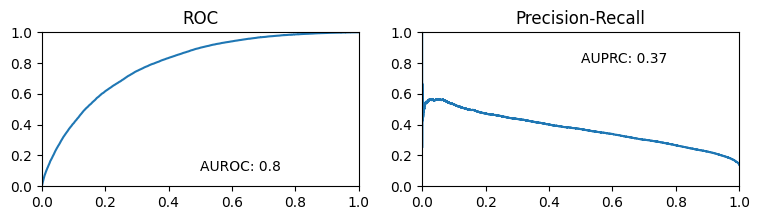

In [9]:
def prediction_fn(data):
    params = lr_model.sample(512)
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [10]:
if dataset == "ovarian":
    test_batch = next(iter(data_factory_factory(batch_size=56)()))
else:
    test_batch = next(iter(data_factory_factory()()))
param_test = lr_model.sample(1024)


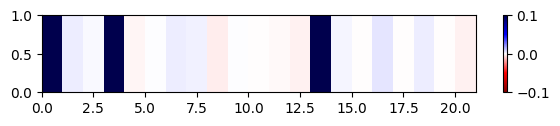

In [11]:
beta = tf.reduce_mean(param_test['beta__'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, vmin=-0.1, vmax=0.1, cmap='seismic_r')
plt.colorbar(im)

In [43]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    delta_beta = params["beta__"] - self.surrogate_distribution.model["beta__"].mean()
    delta_beta = delta_beta / self.surrogate_distribution.model["beta__"].variance()
    delta_intercept = (
        params["intercept__"] - self.surrogate_distribution.model["intercept__"].mean()
    )
    delta_intercept = (
        delta_intercept / self.surrogate_distribution.model["intercept__"].variance()
    )
    


    # log-likelihood descent

    def T_ll(beta, intercept, X, y, hbar):
        mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = y * tf.math.log(sigma) + (1 - y) * tf.math.log(1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        intercept_sd = self.surrogate_distribution.model["intercept__"].variance()**0.5
        beta_sd = self.surrogate_distribution.model["beta__"].variance()**0.5
        
        standardized = tf.concat([Q_beta/beta_sd, Q_intercept/intercept_sd], axis=-1)
        standardized = tf.reduce_max(standardized, axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[..., tf.newaxis]

        h = hbar / standardized
        J = tf.math.abs(
            1.0 + h * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :] * (sigma * (1 - sigma))[..., tf.newaxis]
        )[..., 0]
        beta_ll = beta + h * Q_beta
        intercept_ll = intercept + h * Q_intercept
        return beta_ll, intercept_ll, J

    def T_kl(beta, intercept, X, y, hbar):
        mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = y * tf.math.log(sigma) + (1 - y) * tf.math.log(1 - sigma)
        if variational:
            log_pi_beta = self.surrogate_distribution.model["beta__"].log_prob(
                params["beta__"]
            )
            log_pi_intercept = self.surrogate_distribution.model[
                "intercept__"
            ].log_prob(params["intercept__"])
            log_pi = log_pi_beta + log_pi_intercept
            log_pi -= tf.reduce_max(log_pi, axis=0)
        else:
            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
        # Common

        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        dQ = (
            tf.math.exp(log_pi[..., tf.newaxis])
            / ell
            * (
                (log_ell_prime**2 + log_ell_doubleprime)
                * (1 + tf.math.reduce_sum(X**2, -1))
                + log_ell_prime
                * (
                    delta_intercept[:, :, 0]
                    + tf.reduce_sum(delta_beta * X, axis=-1, keepdims=False)
                )
            )
        )
        h = hbar * 2 / tf.reduce_max(tf.math.abs(dQ) + 1, axis=0)[..., tf.newaxis]
        Q_beta = (
            -tf.math.exp(log_pi[..., tf.newaxis, tf.newaxis])
            * (log_ell_prime / ell)[..., tf.newaxis]
            * data["X"]
        )
        Q_intercept = (
            -tf.math.exp(log_pi[..., tf.newaxis, tf.newaxis])
            * (log_ell_prime / ell)[..., tf.newaxis]
        )
        intercept_sd = self.surrogate_distribution.model["intercept__"].variance()**0.5
        beta_sd = self.surrogate_distribution.model["beta__"].variance()**0.5
        
        standardized = tf.concat([Q_beta/beta_sd, Q_intercept/intercept_sd], axis=-1)
        standardized = tf.reduce_max(standardized, axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[..., tf.newaxis]

        h = hbar / standardized
        
        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        J = tf.math.abs(1 + h[..., 0] * dQ)
        return beta_kl, intercept_kl, J

    # variance descent -(log ell)'/l

    def T_I(beta, intercept, X, y, hbar):
        mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = y * tf.math.log(sigma) + (1 - y) * tf.math.log(1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        intercept_sd = self.surrogate_distribution.model["intercept__"].variance()**0.5
        beta_sd = self.surrogate_distribution.model["beta__"].variance()**0.5

        Q = tf.ones_like(log_ell_prime)*3
        return beta + Q[..., tf.newaxis]*beta_sd, intercept + Q[..., tf.newaxis]*intercept_sd, tf.ones_like(Q)

    def T_var(beta, intercept, X, y, hbar):
        mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = y * tf.math.log(sigma) + (1 - y) * tf.math.log(1 - sigma)
        if variational:
            log_pi_beta = self.surrogate_distribution.model["beta__"].log_prob(
                params["beta__"]
            )
            log_pi_intercept = self.surrogate_distribution.model[
                "intercept__"
            ].log_prob(params["intercept__"])
            log_pi = log_pi_beta + log_pi_intercept
            log_pi -= tf.reduce_max(log_pi, axis=0)
        else:
            log_pi = tf.reduce_sum(log_ell, axis=1)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        onesigmaell = 1 - sigma - log_ell_prime
        eigen = (
            tf.math.exp(log_pi[..., tf.newaxis]) * ((sigma / ell) ** 2) * onesigmaell
        )
        eigen *= 2 * onesigmaell * (
            1 + tf.math.reduce_sum(X**2, -1, keepdims=False)
        ) - (
            delta_intercept[..., 0]
            + tf.reduce_sum(delta_beta * X, axis=-1, keepdims=False)
        )
        dQ = eigen

        Q_intercept = (
            tf.math.exp(log_pi[..., tf.newaxis, tf.newaxis])
            * ((sigma / ell) ** 2 * (1 - sigma - log_ell_prime))[..., tf.newaxis]
        )
        Q_beta = Q_intercept * X
        intercept_sd = self.surrogate_distribution.model["intercept__"].variance()**0.5
        beta_sd = self.surrogate_distribution.model["beta__"].variance()**0.5
        
        standardized = tf.concat([Q_beta/beta_sd, Q_intercept/intercept_sd], axis=-1)
        standardized = tf.reduce_max(standardized, axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[..., tf.newaxis]

        h = tf.where(
            tf.math.abs(standardized) > 1e-14,
            hbar / standardized,
            tf.zeros_like(standardized)
        )
        return (
            beta + h * Q_beta,
            intercept + h * Q_intercept,
            tf.math.abs(1 + h[..., 0] * dQ),
        )

    def IS(beta, intercept, Q, hbar):
        beta_new, intercept_new, J = Q(
            beta,
            intercept,
            tf.cast(data["X"], tf.float64),
            tf.squeeze(tf.cast(data["y"], tf.float64)),
            hbar,
        )

        mu = tf.reduce_sum(beta * data["X"], axis=-1) + intercept[..., 0]
        mu_new = tf.reduce_sum(beta_new * data["X"], axis=-1) + intercept_new[..., 0]
        sigma = tf.math.sigmoid(mu)
        sigma_new = tf.math.sigmoid(mu_new)
        ell = tf.squeeze(tf.cast(data["y"], tf.float64)) * sigma + (
            1 - tf.squeeze(tf.cast(data["y"], tf.float64))
        ) * (1 - sigma)
        log_ell = tf.squeeze(tf.cast(data["y"], tf.float64)) * tf.math.log(sigma) + (
            1 - tf.squeeze(tf.cast(data["y"], tf.float64))
        ) * tf.math.log(1 - sigma)
        ell_new = tf.squeeze(tf.cast(data["y"], tf.float64)) * (sigma_new) + (
            1 - tf.squeeze(tf.cast(data["y"], tf.float64))
        ) * (1 - sigma_new)
        log_ell_new = tf.squeeze(tf.cast(data["y"], tf.float64)) * tf.math.log(
            sigma_new
        ) + (1 - tf.squeeze(tf.cast(data["y"], tf.float64))) * tf.math.log(
            1 - sigma_new
        )

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            delta_log_pi_beta = (
                beta - self.surrogate_distribution.model["beta__"].mean()
            ) ** 2 - (
                beta_new - self.surrogate_distribution.model["beta__"].mean()
            ) ** 2
            delta_log_pi_beta = (
                0.5
                * delta_log_pi_beta
                / self.surrogate_distribution.model["beta__"].variance()
            )

            delta_log_pi_intercept = (
                intercept - self.surrogate_distribution.model["intercept__"].mean()
            ) ** 2 - (
                intercept_new
                - self.surrogate_distribution.model["intercept__"].mean()[0]
            ) ** 2
            delta_log_pi_intercept = (
                0.5
                * delta_log_pi_intercept
                / self.surrogate_distribution.model["intercept__"].variance()[0, 0]
            )
            delta_log_pi = (
                tf.reduce_sum(delta_log_pi_beta, axis=-1)
                + delta_log_pi_intercept[..., 0]
            )
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = (
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * data["X"], -1)
                + intercept_new
            )
            ell_cross = tf.reduce_sum(
                ell_cross, -1
            )  # this is the likelihood portion of pi(T(theta))

            transformed = params.copy()
            transformed["beta__"] = beta_new
            transformed["intercept__"] = intercept_new

            log_pi_new = self.prior_distribution.log_prob(
                {
                    "regression_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.regression_var_list
                    },
                    "intercept_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.intercept_var_list
                    },
                }
            )[:, tf.newaxis]
            log_pi_new += ell_cross
            log_pi_old = self.surrogate_distribution.log_prob(params)
            # Incorporate the prior
            delta_log_pi = (log_pi_new - log_pi_old[:, tf.newaxis])
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=1, keepdims=True
            )

        log_eta_weights = tf.cast(delta_log_pi, tf.float64) - tf.cast(
            log_ell_new, tf.float64
        )

        eta_weights = tf.math.exp(log_eta_weights) * tf.cast(J, tf.float64)

        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)
        r_pi = tf.reduce_max(
            tf.reduce_max(delta_log_pi, axis=0) - tf.reduce_min(delta_log_pi, axis=0)
        )
        r_ell = tf.reduce_max(
            tf.reduce_max(log_ell_new, axis=0) - tf.reduce_min(log_ell_new, axis=0)
        )
        r = tf.reduce_max(
            tf.reduce_max(eta_weights, axis=0) / tf.reduce_min(eta_weights, axis=0)
        )
        # r_J = tf.reduce_max(tf.reduce_max(J, axis=0)-tf.reduce_min(J, axis=0))

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = entropy(eta_weights)
        psis_entropy = entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis
        )

    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll
    ) = IS(params["beta__"], params["intercept__"], T_ll, hbar)
    eta_I, eta_I_psis, p_loo_I, p_loo_I_sd, ll_loo_I, ll_loo_I_sd, S_I, k_I, p_psis_I, ll_psis_I = IS(
        params["beta__"], params["intercept__"], T_I, hbar
    )
    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl
    ) = IS(params["beta__"], params["intercept__"], T_kl, hbar)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var
    ) = IS(params["beta__"], params["intercept__"], T_var, hbar)

    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var
        },
    }


param_test = lr_model.sample(128)

loo = adaptive_is_loo(lr_model, test_batch, param_test, .01, variational=False)

for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.5: {np.sum(loo[T]['khat']>0.5)}"
    )

I: 0.0013701981621697047 entropy: 38.15209571559766 khat>0.5: 0
LL: 0.0012134863835068 entropy: 38.1521081785492 khat>0.5: 2
KL: 0.0012134863835068 entropy: 38.1520897872556 khat>0.5: 0
Var: 0.0012650320456923225 entropy: 38.15211032478844 khat>0.5: 0


# Compute LOO AU ROC/PRC

In [16]:
step_size = 0.1
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_loo']
    return pred



In [17]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



Step-away LOO

(0.0, 1.0)

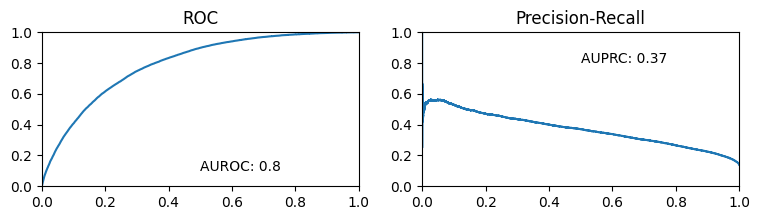

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

(0.0, 1.0)

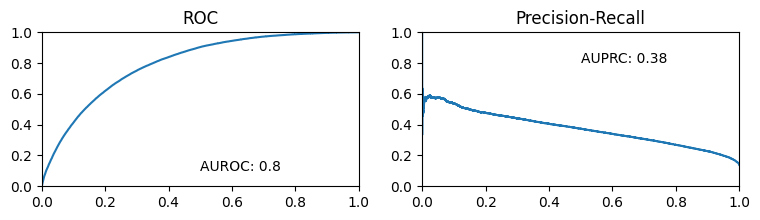

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

In [20]:
bench['auroc']['auroc']

0.7954787895285736

In [21]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(56)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=False)]

0it [00:00, ?it/s]

4530it [21:12,  3.56it/s]


In [22]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [41]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

In [24]:
khat

{'I': array([ 0.21918849,  0.03583356, -0.0159646 , ...,  0.19963247,
        -0.07139372, -0.08344247]),
 'LL': array([ 0.20384661, -0.08873218, -0.1045828 , ..., -0.0429092 ,
        -0.07501152,  0.11576301]),
 'KL': array([0.15906521, 0.19887902, 0.0274004 , ..., 0.10521939, 0.12863356,
        0.02543671]),
 'Var': array([ 0.09643453, -0.04701303, -0.13549959, ...,  0.14784139,
        -0.06982007, -0.02407821])}

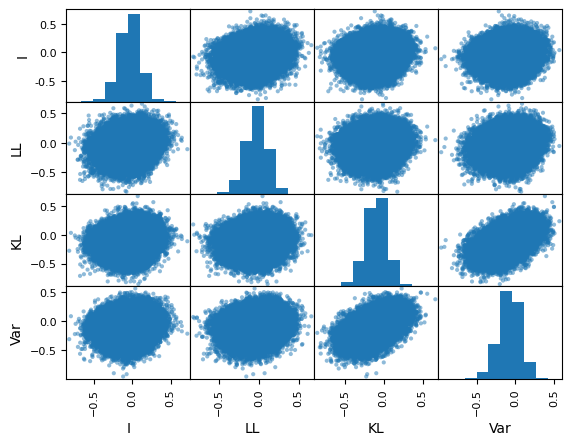

In [45]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


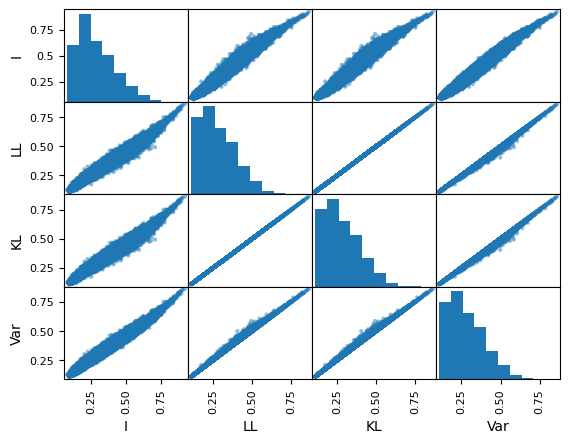

In [42]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [46]:
khat.describe()

,I,LL,KL,Var
count,253680.000000,253680.000000,253680.000000,253680.000000
mean,-0.034704,-0.030085,-0.094422,-0.075924
std,0.136133,0.138272,0.138099,0.137961
min,-0.815955,-0.826816,-0.854546,-0.957637
25%,-0.120566,-0.117241,-0.182663,-0.163586
50%,-0.028828,-0.023370,-0.088495,-0.069169
75%,0.057935,0.064048,-0.000423,0.017730
max,0.715210,0.661629,0.664681,0.565448


In [47]:
khat[khat.I > 0.5]

,I,LL,KL,Var
5983,0.715210,-0.107151,-0.114693,-0.215949
12542,0.574188,-0.025026,-0.005738,-0.064636
39637,0.513092,-0.007406,-0.159980,-0.145197
39660,0.632293,0.052782,-0.016379,-0.015590
44347,0.515681,0.335101,0.104901,0.237189
50731,0.514357,0.103610,0.085249,0.164728
50925,0.596208,0.131464,-0.290290,-0.143322
81632,0.504745,-0.054527,-0.045315,-0.201858
83703,0.544788,0.033238,0.084987,0.114461
89519,0.514583,-0.046765,-0.146893,-0.128465


In [49]:
(khat>0.5).describe()

,I,LL,KL,Var
count,253680,253680,253680,253680
unique,2,2,2,2
top,False,False,False,False
freq,253654,253654,253675,253678
